In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import glob 
import keras
import pathlib
import tensorflow as tf
import tensorflow_addons as tfa
import skimage.color as scc

from skimage import io
from random import randint
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ID
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional

In [20]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [134]:
pip install np_utils

     ---------------------------------------- 62.0/62.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56454 sha256=93e3ed86a17c61397616d22db8edebcb7a0d1e901588f9333a9a250742ef5c5e
  Stored in directory: c:\users\sriya nukala\appdata\local\pip\cache\wheels\c9\5e\52\216e2fa9b02d46b865d8160e7fe29dcf98f89a2fb7be254877
Successfully built np_utils
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow_addons

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.11.0-py3-none-any.whl (235 kB)
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
Note: you may need to restart the kernel to use updated packages.


In [23]:
dataset_path = r'C:\Users\Sriya Nukala\Downloads\Dataset1\gaussian_filtered_images'
filepaths=[]
labels=[]

In [24]:
folds = os.listdir(dataset_path)

In [25]:
folds

['export.pkl', 'Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [26]:
for fold in folds:
    foldpath = os.path.join(dataset_path, fold)  
    # skip export.pkl file
    if pathlib.Path(foldpath).suffix == '':
        filelist = os.listdir(foldpath)

        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

In [27]:
img_paths = pd.Series(filepaths, name= 'filepaths')
img_labels = pd.Series(labels, name='labels')
dataset = pd.concat([img_paths, img_labels], axis= 1)

In [28]:
dataset

filepaths  labels
0     C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...    Mild
1     C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...    Mild
2     C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...    Mild
3     C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...    Mild
4     C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...    Mild
...                                                 ...     ...
3657  C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...  Severe
3658  C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...  Severe
3659  C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...  Severe
3660  C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...  Severe
3661  C:\Users\Sriya Nukala\Downloads\Dataset1\gauss...  Severe

[3662 rows x 2 columns]

In [29]:
batch_size=3662
img=224
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

gen=ID()
data_gen = gen.flow_from_dataframe( dataset,x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)


Found 3662 validated image filenames belonging to 5 classes.


In [30]:
img_data, img_labels = data_gen.next()

In [31]:
print(img_data.shape, img_labels.shape)

(3662, 224, 224, 3) (3662, 5)


In [32]:
img_labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

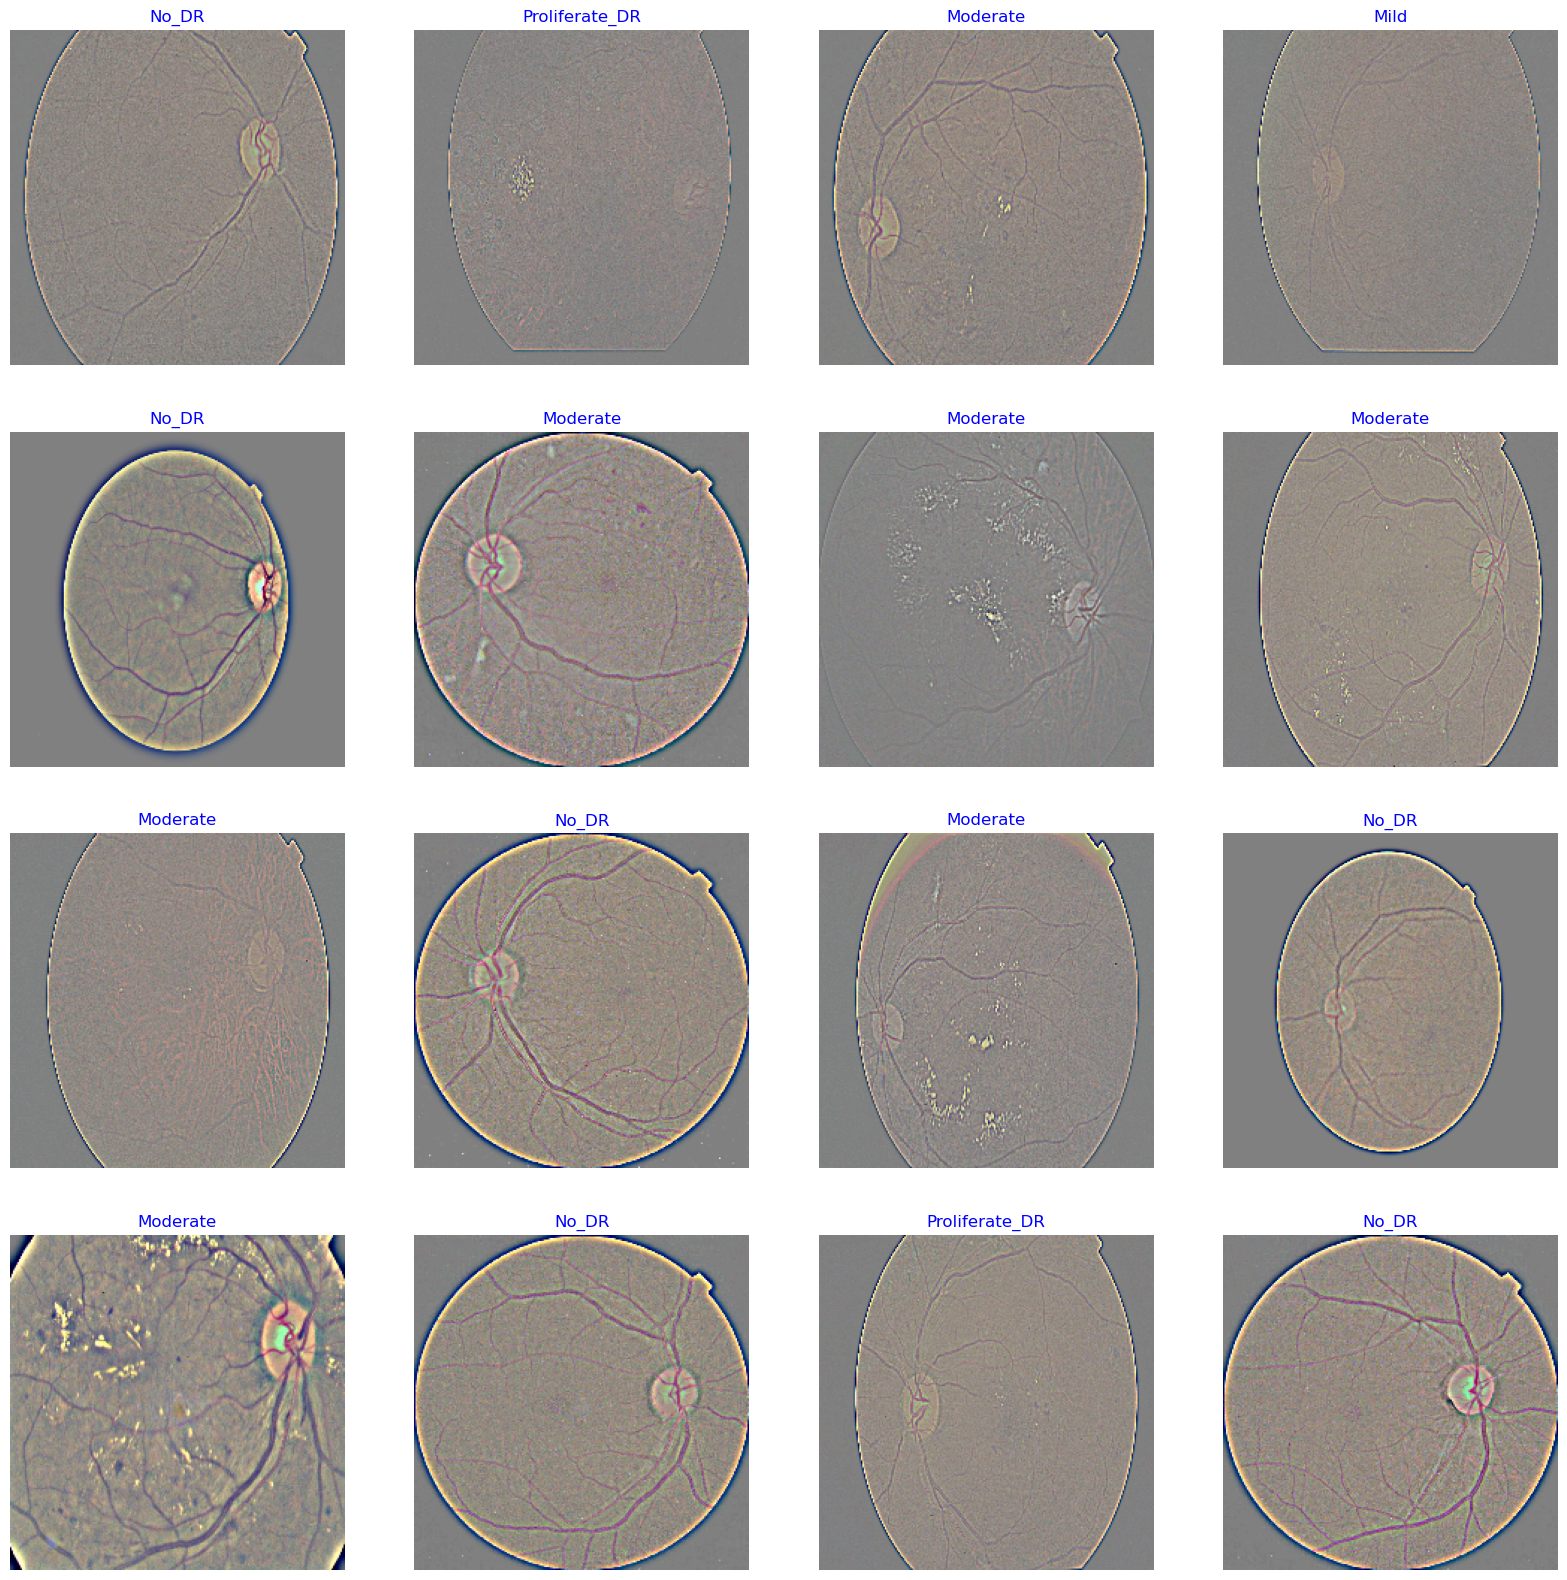

In [33]:
g_dict = data_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(data_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [34]:
train_data, test_data, train_labels, test_labels = train_test_split(img_data, img_labels, test_size = 0.25, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.25, random_state=42)

In [35]:
# sm = SMOTE(random_state=42)

# train_data1, train_labels1 = sm.fit_resample(train_data.reshape(-1, img * img * 3), train_labels)

# train_data2 = train_data1.reshape(-1, img, img, 3)

# print(train_data2.shape, train_labels1.shape)

In [ ]:
# test_data1, test_labels1 = sm.fit_resample(test_data.reshape(-1, img * img * 3), test_labels)

# test_data2 = test_data1.reshape(-1, img, img, 3)

# print(test_data2.shape, test_labels1.shape)

In [ ]:
# val_data1, val_labels1 = sm.fit_resample(val_data.reshape(-1, img * img * 3), val_labels)

# val_data2 = val_data1.reshape(-1, img, img, 3)

# print(val_data2.shape, val_labels1.shape)

In [36]:
from tensorflow.keras.applications import NASNetMobile
# from tensorflow.keras.applications.mobilenetV2 import MobileNetV2
from tensorflow.keras.models import Model
from keras.layers import LSTM, TimeDistributed,Bidirectional

In [37]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
           tf.keras.metrics.AUC(name='AUC'),
           tfa.metrics.F1Score(num_classes=5)]

In [38]:
# mobnet= tf.keras.applications.MobileNet(input_shape = (224,224,3), weights = 'imagenet', include_top = False)
# for layer in enetb3.layers:
#     layer.trainable = False
# x = Conv2D(64, kernel_size=(3,3),activation='relu')(mobnet.output)
# x = TimeDistributed(LSTM(16,activation="relu",return_sequences=False))(x)
# x = Dropout(0.5)(x)
# x = BatchNormalization()(x)
# x = Flatten()(x)
# # x = Dense(128, activation = 'relu',kernel_regularizer=regularizers.l2(0.001))(x) 
# x = Dense(64, activation = 'relu',kernel_regularizer=regularizers.l2(0.001))(x)

# x = Dense(5, activation = 'softmax')(x) 
# model = Model(inputs = mobnet.input, outputs = x)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

nasnetmobile = NASNetMobile(input_shape = (224,224,3), weights = 'imagenet', include_top = False)
for layer in nasnetmobile.layers:
    layer.trainable = False
x = TimeDistributed(LSTM(32,activation="sigmoid",return_sequences=False))(nasnetmobile.output)
x = Dropout(0.5)(x)
# x = BatchNormalization()(enetb3.output)
# x = Conv2D(64, kernel_size=(5,5),activation='relu')(enetb3.output)
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x) 
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation = 'softmax')(x) 
model = Model(inputs = nasnetmobile.input, outputs = x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

In [39]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 111, 111, 32)         128       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                                  
 activation_188 (Activation  (None, 111, 111, 32)         0         ['stem_bn1[0][0]']      

                                                                     'separable_conv_2_bn_reductio
                                                                    n_right1_stem_1[0][0]']       
                                                                                                  
 separable_conv_1_reduction  (None, 56, 56, 11)           1920      ['separable_conv_1_pad_reducti
 _right2_stem_1 (SeparableC                                         on_right2_stem_1[0][0]']      
 onv2D)                                                                                           
                                                                                                  
 separable_conv_1_pad_reduc  (None, 115, 115, 32)         0         ['activation_195[0][0]']      
 tion_right3_stem_1 (ZeroPa                                                                       
 dding2D)                                                                                         
          

 separable_conv_2_bn_reduct  (None, 56, 56, 11)           44        ['separable_conv_2_reduction_l
 ion_left4_stem_1 (BatchNor                                         eft4_stem_1[0][0]']           
 malization)                                                                                      
                                                                                                  
 reduction_right5_stem_1 (M  (None, 56, 56, 11)           0         ['reduction_pad_1_stem_1[0][0]
 axPooling2D)                                                       ']                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 112, 112, 32)         0         ['adjust_relu_1_stem_2[0][0]']
 ing2D)                                                                                           
                                                                                                  
 reduction

 separable_conv_1_bn_reduct  (None, 28, 28, 22)           88        ['separable_conv_1_reduction_l
 ion_left1_stem_2 (BatchNor                                         eft1_stem_2[0][0]']           
 malization)                                                                                      
                                                                                                  
 separable_conv_1_bn_reduct  (None, 28, 28, 22)           88        ['separable_conv_1_reduction_r
 ion_right1_stem_2 (BatchNo                                         ight1_stem_2[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 activation_201 (Activation  (None, 28, 28, 22)           0         ['separable_conv_1_bn_reductio
 )                                                                  n_left1_stem_2[0][0]']        
          

 _right2_stem_2 (SeparableC                                                                       
 onv2D)                                                                                           
                                                                                                  
 activation_207 (Activation  (None, 28, 28, 22)           0         ['separable_conv_1_bn_reductio
 )                                                                  n_right3_stem_2[0][0]']       
                                                                                                  
 activation_209 (Activation  (None, 28, 28, 22)           0         ['separable_conv_1_bn_reductio
 )                                                                  n_left4_stem_2[0][0]']        
                                                                                                  
 reduction_left2_stem_2 (Ma  (None, 28, 28, 22)           0         ['reduction_pad_1_stem_2[0][0]
 xPooling2

                                                                                                  
 adjust_conv_2_0 (Conv2D)    (None, 28, 28, 22)           968       ['adjust_avg_pool_2_0[0][0]'] 
                                                                                                  
 activation_210 (Activation  (None, 28, 28, 88)           0         ['reduction_concat_stem_2[0][0
 )                                                                  ]']                           
                                                                                                  
 concatenate_5 (Concatenate  (None, 28, 28, 44)           0         ['adjust_conv_1_0[0][0]',     
 )                                                                   'adjust_conv_2_0[0][0]']     
                                                                                                  
 normal_conv_1_0 (Conv2D)    (None, 28, 28, 44)           3872      ['activation_210[0][0]']      
          

 ft1_0 (SeparableConv2D)                                                                          
                                                                                                  
 separable_conv_2_normal_ri  (None, 28, 28, 44)           2332      ['activation_214[0][0]']      
 ght1_0 (SeparableConv2D)                                                                         
                                                                                                  
 separable_conv_2_normal_le  (None, 28, 28, 44)           3036      ['activation_216[0][0]']      
 ft2_0 (SeparableConv2D)                                                                          
                                                                                                  
 separable_conv_2_normal_ri  (None, 28, 28, 44)           2332      ['activation_218[0][0]']      
 ght2_0 (SeparableConv2D)                                                                         
          

                                                                                                  
 normal_bn_1_1 (BatchNormal  (None, 28, 28, 44)           176       ['normal_conv_1_1[0][0]']     
 ization)                                                                                         
                                                                                                  
 activation_223 (Activation  (None, 28, 28, 44)           0         ['normal_bn_1_1[0][0]']       
 )                                                                                                
                                                                                                  
 activation_225 (Activation  (None, 28, 28, 44)           0         ['adjust_bn_1[0][0]']         
 )                                                                                                
                                                                                                  
 activatio

                                                                                                  
 separable_conv_2_bn_normal  (None, 28, 28, 44)           176       ['separable_conv_2_normal_left
 _left1_1 (BatchNormalizati                                         1_1[0][0]']                   
 on)                                                                                              
                                                                                                  
 separable_conv_2_bn_normal  (None, 28, 28, 44)           176       ['separable_conv_2_normal_righ
 _right1_1 (BatchNormalizat                                         t1_1[0][0]']                  
 ion)                                                                                             
                                                                                                  
 separable_conv_2_bn_normal  (None, 28, 28, 44)           176       ['separable_conv_2_normal_left
 _left2_1 

 activation_241 (Activation  (None, 28, 28, 44)           0         ['adjust_bn_2[0][0]']         
 )                                                                                                
                                                                                                  
 activation_243 (Activation  (None, 28, 28, 44)           0         ['normal_bn_1_2[0][0]']       
 )                                                                                                
                                                                                                  
 separable_conv_1_normal_le  (None, 28, 28, 44)           3036      ['activation_235[0][0]']      
 ft1_2 (SeparableConv2D)                                                                          
                                                                                                  
 separable_conv_1_normal_ri  (None, 28, 28, 44)           2332      ['activation_237[0][0]']      
 ght1_2 (S

 separable_conv_2_bn_normal  (None, 28, 28, 44)           176       ['separable_conv_2_normal_righ
 _right2_2 (BatchNormalizat                                         t2_2[0][0]']                  
 ion)                                                                                             
                                                                                                  
 normal_left3_2 (AveragePoo  (None, 28, 28, 44)           0         ['normal_bn_1_2[0][0]']       
 ling2D)                                                                                          
                                                                                                  
 normal_left4_2 (AveragePoo  (None, 28, 28, 44)           0         ['adjust_bn_2[0][0]']         
 ling2D)                                                                                          
                                                                                                  
 normal_ri

 ft2_3 (SeparableConv2D)                                                                          
                                                                                                  
 separable_conv_1_normal_ri  (None, 28, 28, 44)           2332      ['activation_253[0][0]']      
 ght2_3 (SeparableConv2D)                                                                         
                                                                                                  
 separable_conv_1_normal_le  (None, 28, 28, 44)           2332      ['activation_255[0][0]']      
 ft5_3 (SeparableConv2D)                                                                          
                                                                                                  
 separable_conv_1_bn_normal  (None, 28, 28, 44)           176       ['separable_conv_1_normal_left
 _left1_3 (BatchNormalizati                                         1_3[0][0]']                   
 on)      

 separable_conv_2_bn_normal  (None, 28, 28, 44)           176       ['separable_conv_2_normal_left
 _left5_3 (BatchNormalizati                                         5_3[0][0]']                   
 on)                                                                                              
                                                                                                  
 normal_add_1_3 (Add)        (None, 28, 28, 44)           0         ['separable_conv_2_bn_normal_l
                                                                    eft1_3[0][0]',                
                                                                     'separable_conv_2_bn_normal_r
                                                                    ight1_3[0][0]']               
                                                                                                  
 normal_add_2_3 (Add)        (None, 28, 28, 44)           0         ['separable_conv_2_bn_normal_l
          

 )                                                                  n_right1_reduce_4[0][0]']     
                                                                                                  
 separable_conv_2_reduction  (None, 14, 14, 88)           9944      ['activation_260[0][0]']      
 _left1_reduce_4 (Separable                                                                       
 Conv2D)                                                                                          
                                                                                                  
 separable_conv_2_reduction  (None, 14, 14, 88)           12056     ['activation_262[0][0]']      
 _right1_reduce_4 (Separabl                                                                       
 eConv2D)                                                                                         
                                                                                                  
 activatio

 separable_conv_2_bn_reduct  (None, 14, 14, 88)           352       ['separable_conv_2_reduction_r
 ion_right2_reduce_4 (Batch                                         ight2_reduce_4[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 separable_conv_2_reduction  (None, 14, 14, 88)           9944      ['activation_266[0][0]']      
 _right3_reduce_4 (Separabl                                                                       
 eConv2D)                                                                                         
                                                                                                  
 separable_conv_2_reduction  (None, 14, 14, 88)           8536      ['activation_268[0][0]']      
 _left4_reduce_4 (Separable                                                                       
 Conv2D)  

 adjust_bn_5 (BatchNormaliz  (None, 14, 14, 88)           352       ['concatenate_6[0][0]']       
 ation)                                                                                           
                                                                                                  
 normal_bn_1_5 (BatchNormal  (None, 14, 14, 88)           352       ['normal_conv_1_5[0][0]']     
 ization)                                                                                         
                                                                                                  
 activation_270 (Activation  (None, 14, 14, 88)           0         ['normal_bn_1_5[0][0]']       
 )                                                                                                
                                                                                                  
 activation_272 (Activation  (None, 14, 14, 88)           0         ['adjust_bn_5[0][0]']         
 )        

 separable_conv_2_normal_le  (None, 14, 14, 88)           8536      ['activation_279[0][0]']      
 ft5_5 (SeparableConv2D)                                                                          
                                                                                                  
 separable_conv_2_bn_normal  (None, 14, 14, 88)           352       ['separable_conv_2_normal_left
 _left1_5 (BatchNormalizati                                         1_5[0][0]']                   
 on)                                                                                              
                                                                                                  
 separable_conv_2_bn_normal  (None, 14, 14, 88)           352       ['separable_conv_2_normal_righ
 _right1_5 (BatchNormalizat                                         t1_5[0][0]']                  
 ion)                                                                                             
          

 )                                                                                                
                                                                                                  
 activation_288 (Activation  (None, 14, 14, 88)           0         ['adjust_bn_6[0][0]']         
 )                                                                                                
                                                                                                  
 activation_290 (Activation  (None, 14, 14, 88)           0         ['normal_bn_1_6[0][0]']       
 )                                                                                                
                                                                                                  
 separable_conv_1_normal_le  (None, 14, 14, 88)           9944      ['activation_282[0][0]']      
 ft1_6 (SeparableConv2D)                                                                          
          

 on)                                                                                              
                                                                                                  
 separable_conv_2_bn_normal  (None, 14, 14, 88)           352       ['separable_conv_2_normal_righ
 _right2_6 (BatchNormalizat                                         t2_6[0][0]']                  
 ion)                                                                                             
                                                                                                  
 normal_left3_6 (AveragePoo  (None, 14, 14, 88)           0         ['normal_bn_1_6[0][0]']       
 ling2D)                                                                                          
                                                                                                  
 normal_left4_6 (AveragePoo  (None, 14, 14, 88)           0         ['adjust_bn_6[0][0]']         
 ling2D)  

                                                                                                  
 separable_conv_1_normal_le  (None, 14, 14, 88)           9944      ['activation_298[0][0]']      
 ft2_7 (SeparableConv2D)                                                                          
                                                                                                  
 separable_conv_1_normal_ri  (None, 14, 14, 88)           8536      ['activation_300[0][0]']      
 ght2_7 (SeparableConv2D)                                                                         
                                                                                                  
 separable_conv_1_normal_le  (None, 14, 14, 88)           8536      ['activation_302[0][0]']      
 ft5_7 (SeparableConv2D)                                                                          
                                                                                                  
 separable

 oling2D)                                                                                         
                                                                                                  
 separable_conv_2_bn_normal  (None, 14, 14, 88)           352       ['separable_conv_2_normal_left
 _left5_7 (BatchNormalizati                                         5_7[0][0]']                   
 on)                                                                                              
                                                                                                  
 normal_add_1_7 (Add)        (None, 14, 14, 88)           0         ['separable_conv_2_bn_normal_l
                                                                    eft1_7[0][0]',                
                                                                     'separable_conv_2_bn_normal_r
                                                                    ight1_7[0][0]']               
          

                                                                                                  
 separable_conv_1_bn_normal  (None, 14, 14, 88)           352       ['separable_conv_1_normal_righ
 _right1_8 (BatchNormalizat                                         t1_8[0][0]']                  
 ion)                                                                                             
                                                                                                  
 separable_conv_1_bn_normal  (None, 14, 14, 88)           352       ['separable_conv_1_normal_left
 _left2_8 (BatchNormalizati                                         2_8[0][0]']                   
 on)                                                                                              
                                                                                                  
 separable_conv_1_bn_normal  (None, 14, 14, 88)           352       ['separable_conv_1_normal_righ
 _right2_8

                                                                     'separable_conv_2_bn_normal_r
                                                                    ight2_8[0][0]']               
                                                                                                  
 normal_add_3_8 (Add)        (None, 14, 14, 88)           0         ['normal_left3_8[0][0]',      
                                                                     'adjust_bn_8[0][0]']         
                                                                                                  
 normal_add_4_8 (Add)        (None, 14, 14, 88)           0         ['normal_left4_8[0][0]',      
                                                                     'normal_right4_8[0][0]']     
                                                                                                  
 normal_add_5_8 (Add)        (None, 14, 14, 88)           0         ['separable_conv_2_bn_normal_l
          

 )                                                                                                
                                                                                                  
 separable_conv_2_bn_reduct  (None, 7, 7, 176)            704       ['separable_conv_2_reduction_l
 ion_left1_reduce_8 (BatchN                                         eft1_reduce_8[0][0]']         
 ormalization)                                                                                    
                                                                                                  
 separable_conv_2_bn_reduct  (None, 7, 7, 176)            704       ['separable_conv_2_reduction_r
 ion_right1_reduce_8 (Batch                                         ight1_reduce_8[0][0]']        
 Normalization)                                                                                   
                                                                                                  
 separable

                                                                                                  
 adjust_relu_1_9 (Activatio  (None, 14, 14, 528)          0         ['normal_concat_8[0][0]']     
 n)                                                                                               
                                                                                                  
 reduction_add_2_reduce_8 (  (None, 7, 7, 176)            0         ['reduction_left2_reduce_8[0][
 Add)                                                               0]',                          
                                                                     'separable_conv_2_bn_reductio
                                                                    n_right2_reduce_8[0][0]']     
                                                                                                  
 reduction_left3_reduce_8 (  (None, 7, 7, 176)            0         ['reduction_pad_1_reduce_8[0][
 AveragePo

                                                                                                  
 activation_333 (Activation  (None, 7, 7, 176)            0         ['adjust_bn_9[0][0]']         
 )                                                                                                
                                                                                                  
 activation_335 (Activation  (None, 7, 7, 176)            0         ['adjust_bn_9[0][0]']         
 )                                                                                                
                                                                                                  
 activation_337 (Activation  (None, 7, 7, 176)            0         ['normal_bn_1_9[0][0]']       
 )                                                                                                
                                                                                                  
 separable

 separable_conv_2_bn_normal  (None, 7, 7, 176)            704       ['separable_conv_2_normal_left
 _left2_9 (BatchNormalizati                                         2_9[0][0]']                   
 on)                                                                                              
                                                                                                  
 separable_conv_2_bn_normal  (None, 7, 7, 176)            704       ['separable_conv_2_normal_righ
 _right2_9 (BatchNormalizat                                         t2_9[0][0]']                  
 ion)                                                                                             
                                                                                                  
 normal_left3_9 (AveragePoo  (None, 7, 7, 176)            0         ['normal_bn_1_9[0][0]']       
 ling2D)                                                                                          
          

 separable_conv_1_normal_ri  (None, 7, 7, 176)            32560     ['activation_343[0][0]']      
 ght1_10 (SeparableConv2D)                                                                        
                                                                                                  
 separable_conv_1_normal_le  (None, 7, 7, 176)            35376     ['activation_345[0][0]']      
 ft2_10 (SeparableConv2D)                                                                         
                                                                                                  
 separable_conv_1_normal_ri  (None, 7, 7, 176)            32560     ['activation_347[0][0]']      
 ght2_10 (SeparableConv2D)                                                                        
                                                                                                  
 separable_conv_1_normal_le  (None, 7, 7, 176)            32560     ['activation_349[0][0]']      
 ft5_10 (S

                                                                                                  
 normal_right4_10 (AverageP  (None, 7, 7, 176)            0         ['adjust_bn_10[0][0]']        
 ooling2D)                                                                                        
                                                                                                  
 separable_conv_2_bn_normal  (None, 7, 7, 176)            704       ['separable_conv_2_normal_left
 _left5_10 (BatchNormalizat                                         5_10[0][0]']                  
 ion)                                                                                             
                                                                                                  
 normal_add_1_10 (Add)       (None, 7, 7, 176)            0         ['separable_conv_2_bn_normal_l
                                                                    eft1_10[0][0]',               
          

 _left1_11 (BatchNormalizat                                         1_11[0][0]']                  
 ion)                                                                                             
                                                                                                  
 separable_conv_1_bn_normal  (None, 7, 7, 176)            704       ['separable_conv_1_normal_righ
 _right1_11 (BatchNormaliza                                         t1_11[0][0]']                 
 tion)                                                                                            
                                                                                                  
 separable_conv_1_bn_normal  (None, 7, 7, 176)            704       ['separable_conv_1_normal_left
 _left2_11 (BatchNormalizat                                         2_11[0][0]']                  
 ion)                                                                                             
          

 normal_add_2_11 (Add)       (None, 7, 7, 176)            0         ['separable_conv_2_bn_normal_l
                                                                    eft2_11[0][0]',               
                                                                     'separable_conv_2_bn_normal_r
                                                                    ight2_11[0][0]']              
                                                                                                  
 normal_add_3_11 (Add)       (None, 7, 7, 176)            0         ['normal_left3_11[0][0]',     
                                                                     'adjust_bn_11[0][0]']        
                                                                                                  
 normal_add_4_11 (Add)       (None, 7, 7, 176)            0         ['normal_left4_11[0][0]',     
                                                                     'normal_right4_11[0][0]']    
          

 tion)                                                                                            
                                                                                                  
 separable_conv_1_bn_normal  (None, 7, 7, 176)            704       ['separable_conv_1_normal_left
 _left5_12 (BatchNormalizat                                         5_12[0][0]']                  
 ion)                                                                                             
                                                                                                  
 activation_366 (Activation  (None, 7, 7, 176)            0         ['separable_conv_1_bn_normal_l
 )                                                                  eft1_12[0][0]']               
                                                                                                  
 activation_368 (Activation  (None, 7, 7, 176)            0         ['separable_conv_1_bn_normal_r
 )        

                                                                     'normal_bn_1_12[0][0]']      
                                                                                                  
 normal_concat_12 (Concaten  (None, 7, 7, 1056)           0         ['adjust_bn_12[0][0]',        
 ate)                                                                'normal_add_1_12[0][0]',     
                                                                     'normal_add_2_12[0][0]',     
                                                                     'normal_add_3_12[0][0]',     
                                                                     'normal_add_4_12[0][0]',     
                                                                     'normal_add_5_12[0][0]']     
                                                                                                  
 activation_375 (Activation  (None, 7, 7, 1056)           0         ['normal_concat_12[0][0]']    
 )        

In [40]:
history = model.fit(train_data,train_labels, epochs= 35,verbose= 1, validation_data= (val_data,val_labels), 
                    validation_steps= None, shuffle= False,batch_size=32)

Epoch 1/35
65/65 [==============================] - 70s 908ms/step - loss: 1.2075 - Accuracy: 0.5478 - AUC: 0.8097 - f1_score: 0.2580 - val_loss: 0.9735 - val_Accuracy: 0.6448 - val_AUC: 0.8779 - val_f1_score: 0.2802
Epoch 2/35
65/65 [==============================] - 53s 815ms/step - loss: 1.0447 - Accuracy: 0.6357 - AUC: 0.8604 - f1_score: 0.2846 - val_loss: 0.8948 - val_Accuracy: 0.6667 - val_AUC: 0.8980 - val_f1_score: 0.2919
Epoch 3/35
65/65 [==============================] - 52s 810ms/step - loss: 0.9855 - Accuracy: 0.6493 - AUC: 0.8770 - f1_score: 0.2898 - val_loss: 0.8715 - val_Accuracy: 0.6798 - val_AUC: 0.9028 - val_f1_score: 0.2951
Epoch 4/35
65/65 [==============================] - 52s 808ms/step - loss: 0.9464 - Accuracy: 0.6756 - AUC: 0.8865 - f1_score: 0.3005 - val_loss: 0.8459 - val_Accuracy: 0.6841 - val_AUC: 0.9087 - val_f1_score: 0.2999
Epoch 5/35
65/65 [==============================] - 52s 809ms/step - loss: 0.9167 - Accuracy: 0.6804 - AUC: 0.8927 - f1_score: 0.298

In [41]:
train_scores = model.evaluate(train_data, train_labels)
val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data,test_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

29/29 [==============================] - 26s 899ms/step - loss: 0.7867 - Accuracy: 0.7227 - AUC: 0.9241 - f1_score: 0.4112
Training Accuracy: 76.15%
Validation Accuracy: 70.60%
Testing Accuracy: 72.27%


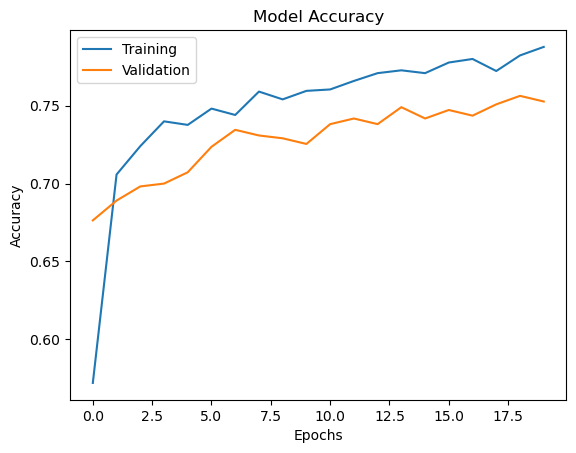

In [21]:
fig, ax = plt.subplots()
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig('Model Accuracy_efficientnetb3_nsm_nes-79.5.png', format='png', dpi=300)

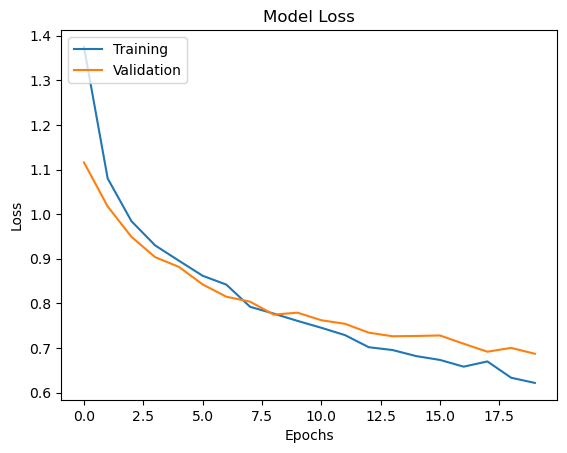

In [22]:
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig('Model Loss_efficientnetb3_nsm_nes-79.5.png', format='png', dpi=300)

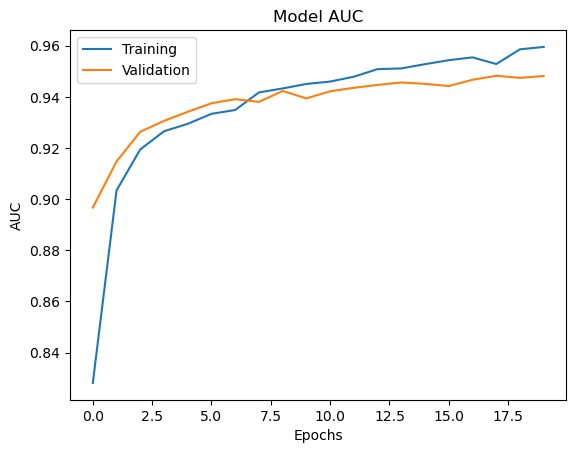

In [23]:
fig, ax = plt.subplots()
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig('Model AUC_efficientnetb3_nsm_nes-79.5.png', format='png', dpi=300)

In [24]:
pred_labels = model.predict(test_data)

29/29 [==============================] - 79s 3s/step


In [25]:
from sklearn import metrics
auc = metrics.roc_auc_score(test_labels,pred_labels,multi_class='ovo')
auc

0.9154065337084475

In [26]:
auc

0.9154065337084475

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)
conf_arr

array([[ 49,  29,   8,   0,   0],
       [ 11, 229,   8,   0,   0],
       [  9,   2, 449,   0,   0],
       [  4,  69,   1,   0,   0],
       [  1,  47,   0,   0,   0]], dtype=int64)

In [29]:
CLASSES=['No_DR','Mild','Moderate','Severe','Proliferate_DR']

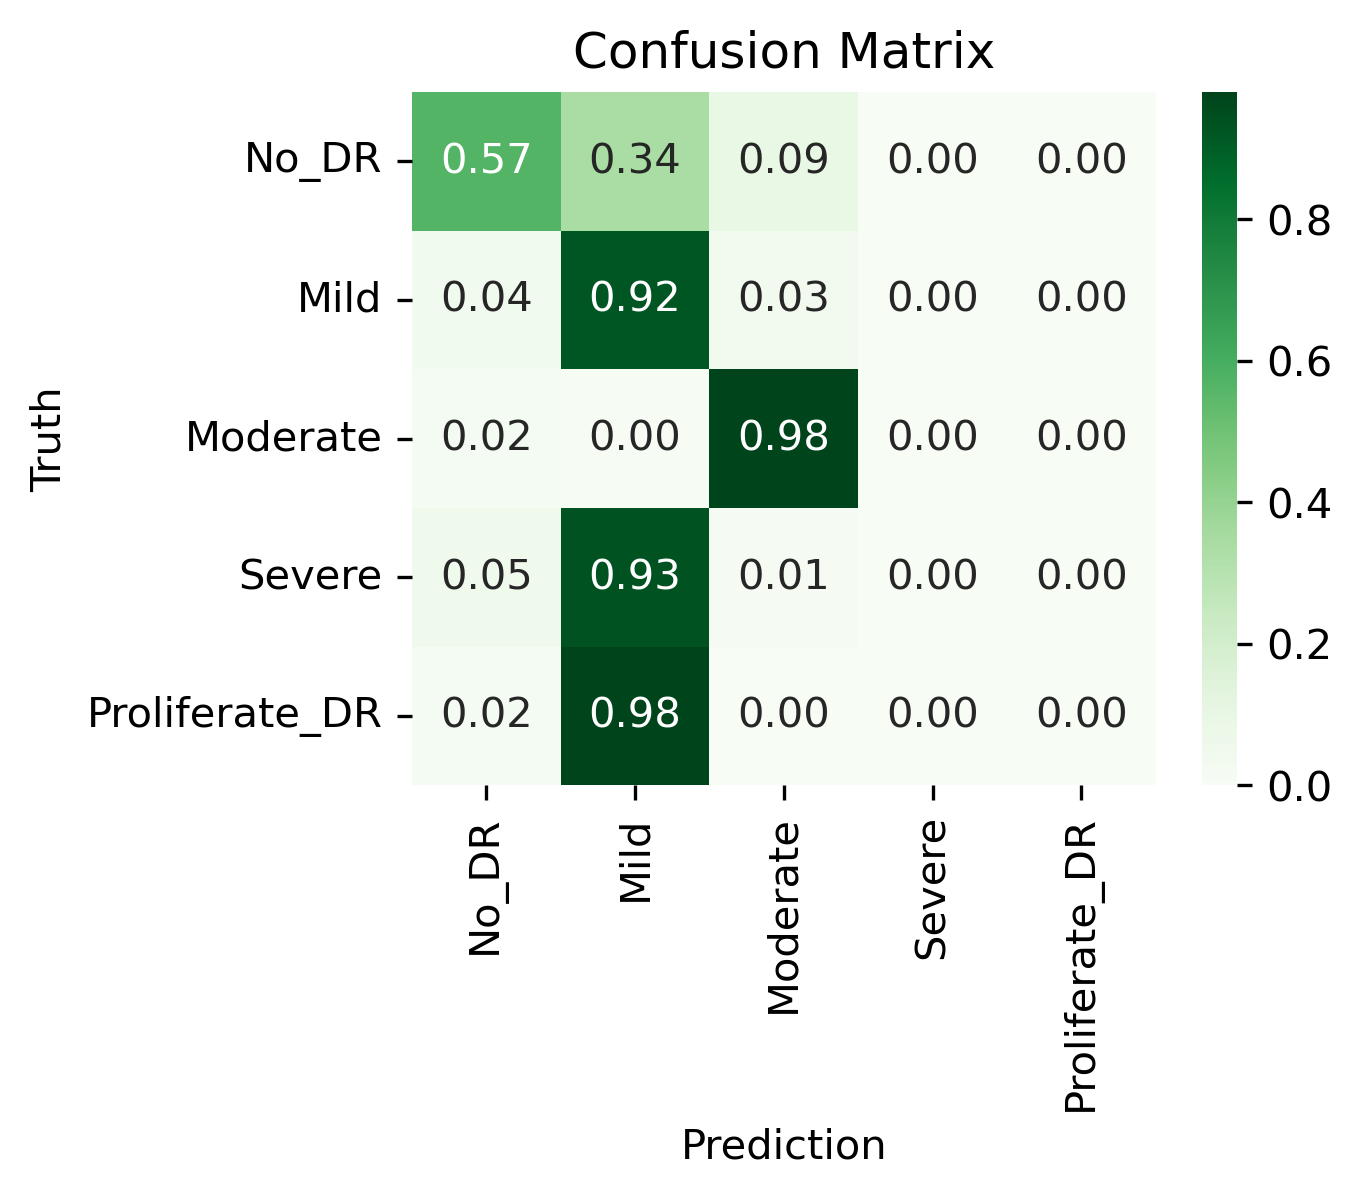

In [30]:
# pred_ls = np.argmax(pred_labels, axis=1)
# test_ls = np.argmax(test_labels, axis=1)

# conf_arr = confusion_matrix(test_ls, pred_ls)
cmn = conf_arr.astype('float') / conf_arr.sum(axis=1)[:, np.newaxis]
fig=plt.figure(figsize=(4,3), dpi=300, facecolor='w', edgecolor='k')

ax = sns.heatmap(cmn, cmap='Greens', annot=True, fmt=".2f", xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)
ax.figure.savefig('confmatrix_ENETB3-79.5.png', format='png', dpi=300)

In [31]:
pred_labels1=np.argmax(pred_labels,axis=1)
test_labels1=np.argmax(test_labels,axis=1)

In [32]:
from sklearn.preprocessing import label_binarize

In [33]:
predlabels_new=label_binarize(pred_labels1,classes=np.unique(pred_labels1))
classes=np.unique(pred_labels1)

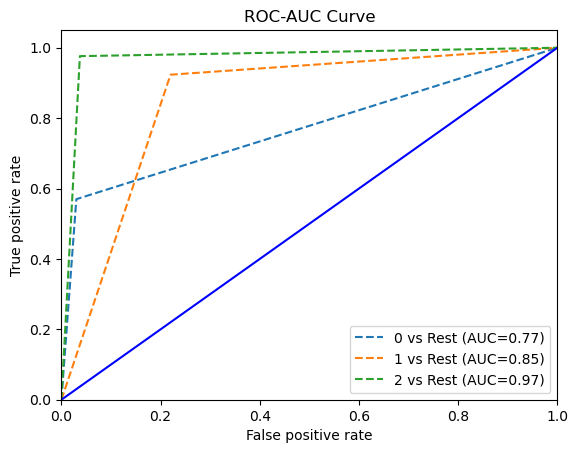

In [34]:
fig, ax = plt.subplots()
f_p_r=dict()
t_p_r = dict()
thres=dict()
rocauc_curve= dict()
total_no_of_class = classes.shape[0]
for i in range(total_no_of_class):    
    f_p_r[i], t_p_r[i], thres[i] = metrics.roc_curve(test_labels[:,i],predlabels_new[:,i])
    rocauc_curve[i] = metrics.auc(f_p_r[i], t_p_r[i])    
    plt.plot(f_p_r[i], t_p_r[i], linestyle='--',label='%s vs Rest (AUC=%0.2f)'%(classes[i],rocauc_curve[i]))

plt.plot([0,1],[0,1],'b-')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('ROC-AUC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()
fig.savefig('ROCAUC_EfficientNetB3-79.5.png', format='png', dpi=300)

In [35]:
from sklearn.metrics import classification_report

In [36]:
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)
print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                precision    recall  f1-score   support

         No_DR       0.66      0.57      0.61        86
          Mild       0.61      0.92      0.73       248
      Moderate       0.96      0.98      0.97       460
        Severe       0.00      0.00      0.00        74
Proliferate_DR       0.00      0.00      0.00        48

     micro avg       0.79      0.79      0.79       916
     macro avg       0.45      0.49      0.46       916
  weighted avg       0.71      0.79      0.74       916
   samples avg       0.79      0.79      0.79       916



C:\Users\SNEHA\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


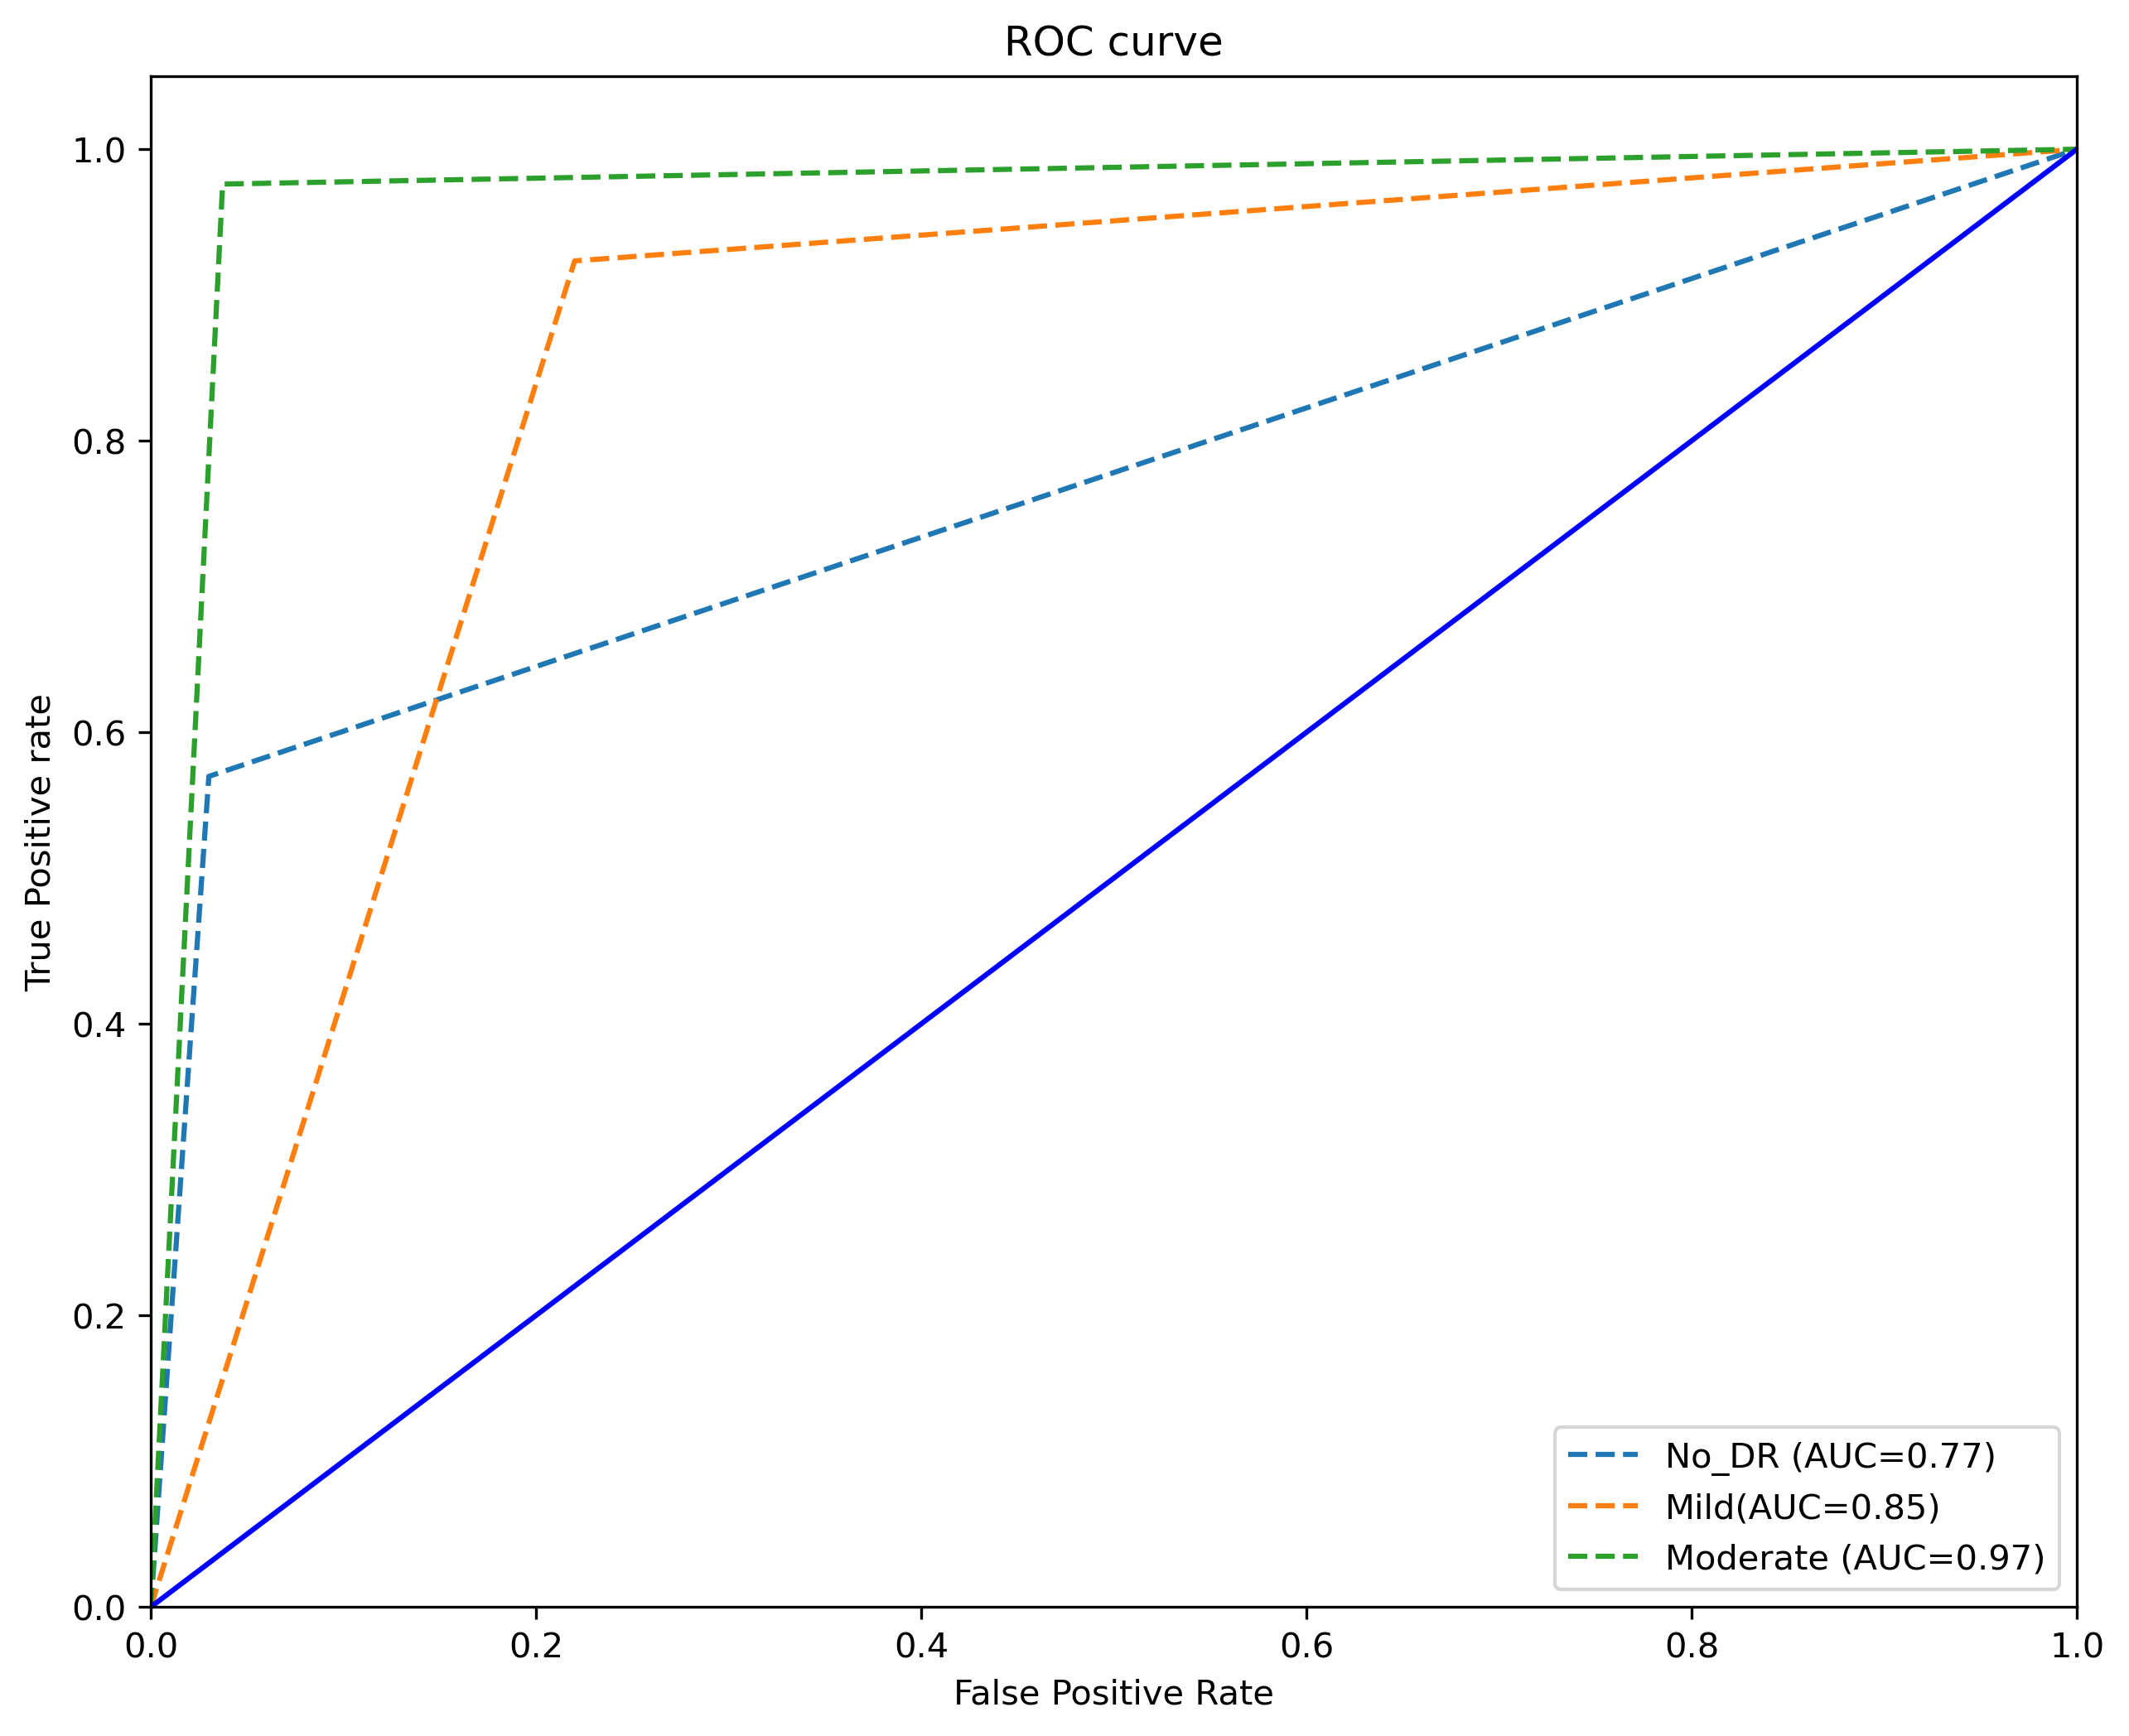

In [39]:
pr = dict()
fpr=dict()
tpr = dict()
thresh =dict()
roc_auc = dict()

n_class = classes.shape[0]
fig=plt.figure(figsize=(10, 8), dpi=300)
for i, in zip(range(n_class)):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(test_labels[:,i],predlabels_new[:,i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    if classes[i]==0:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='No_DR (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==1:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Mild(AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==2:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Moderate (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==3:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Severe (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==4:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Proliferate_DR (AUC=%0.2f)'%(roc_auc[i]))
plt.plot([0,1],[0,1],'b-')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()
fig.savefig('myfig_EfficientNet-79_5.png',dpi=300)

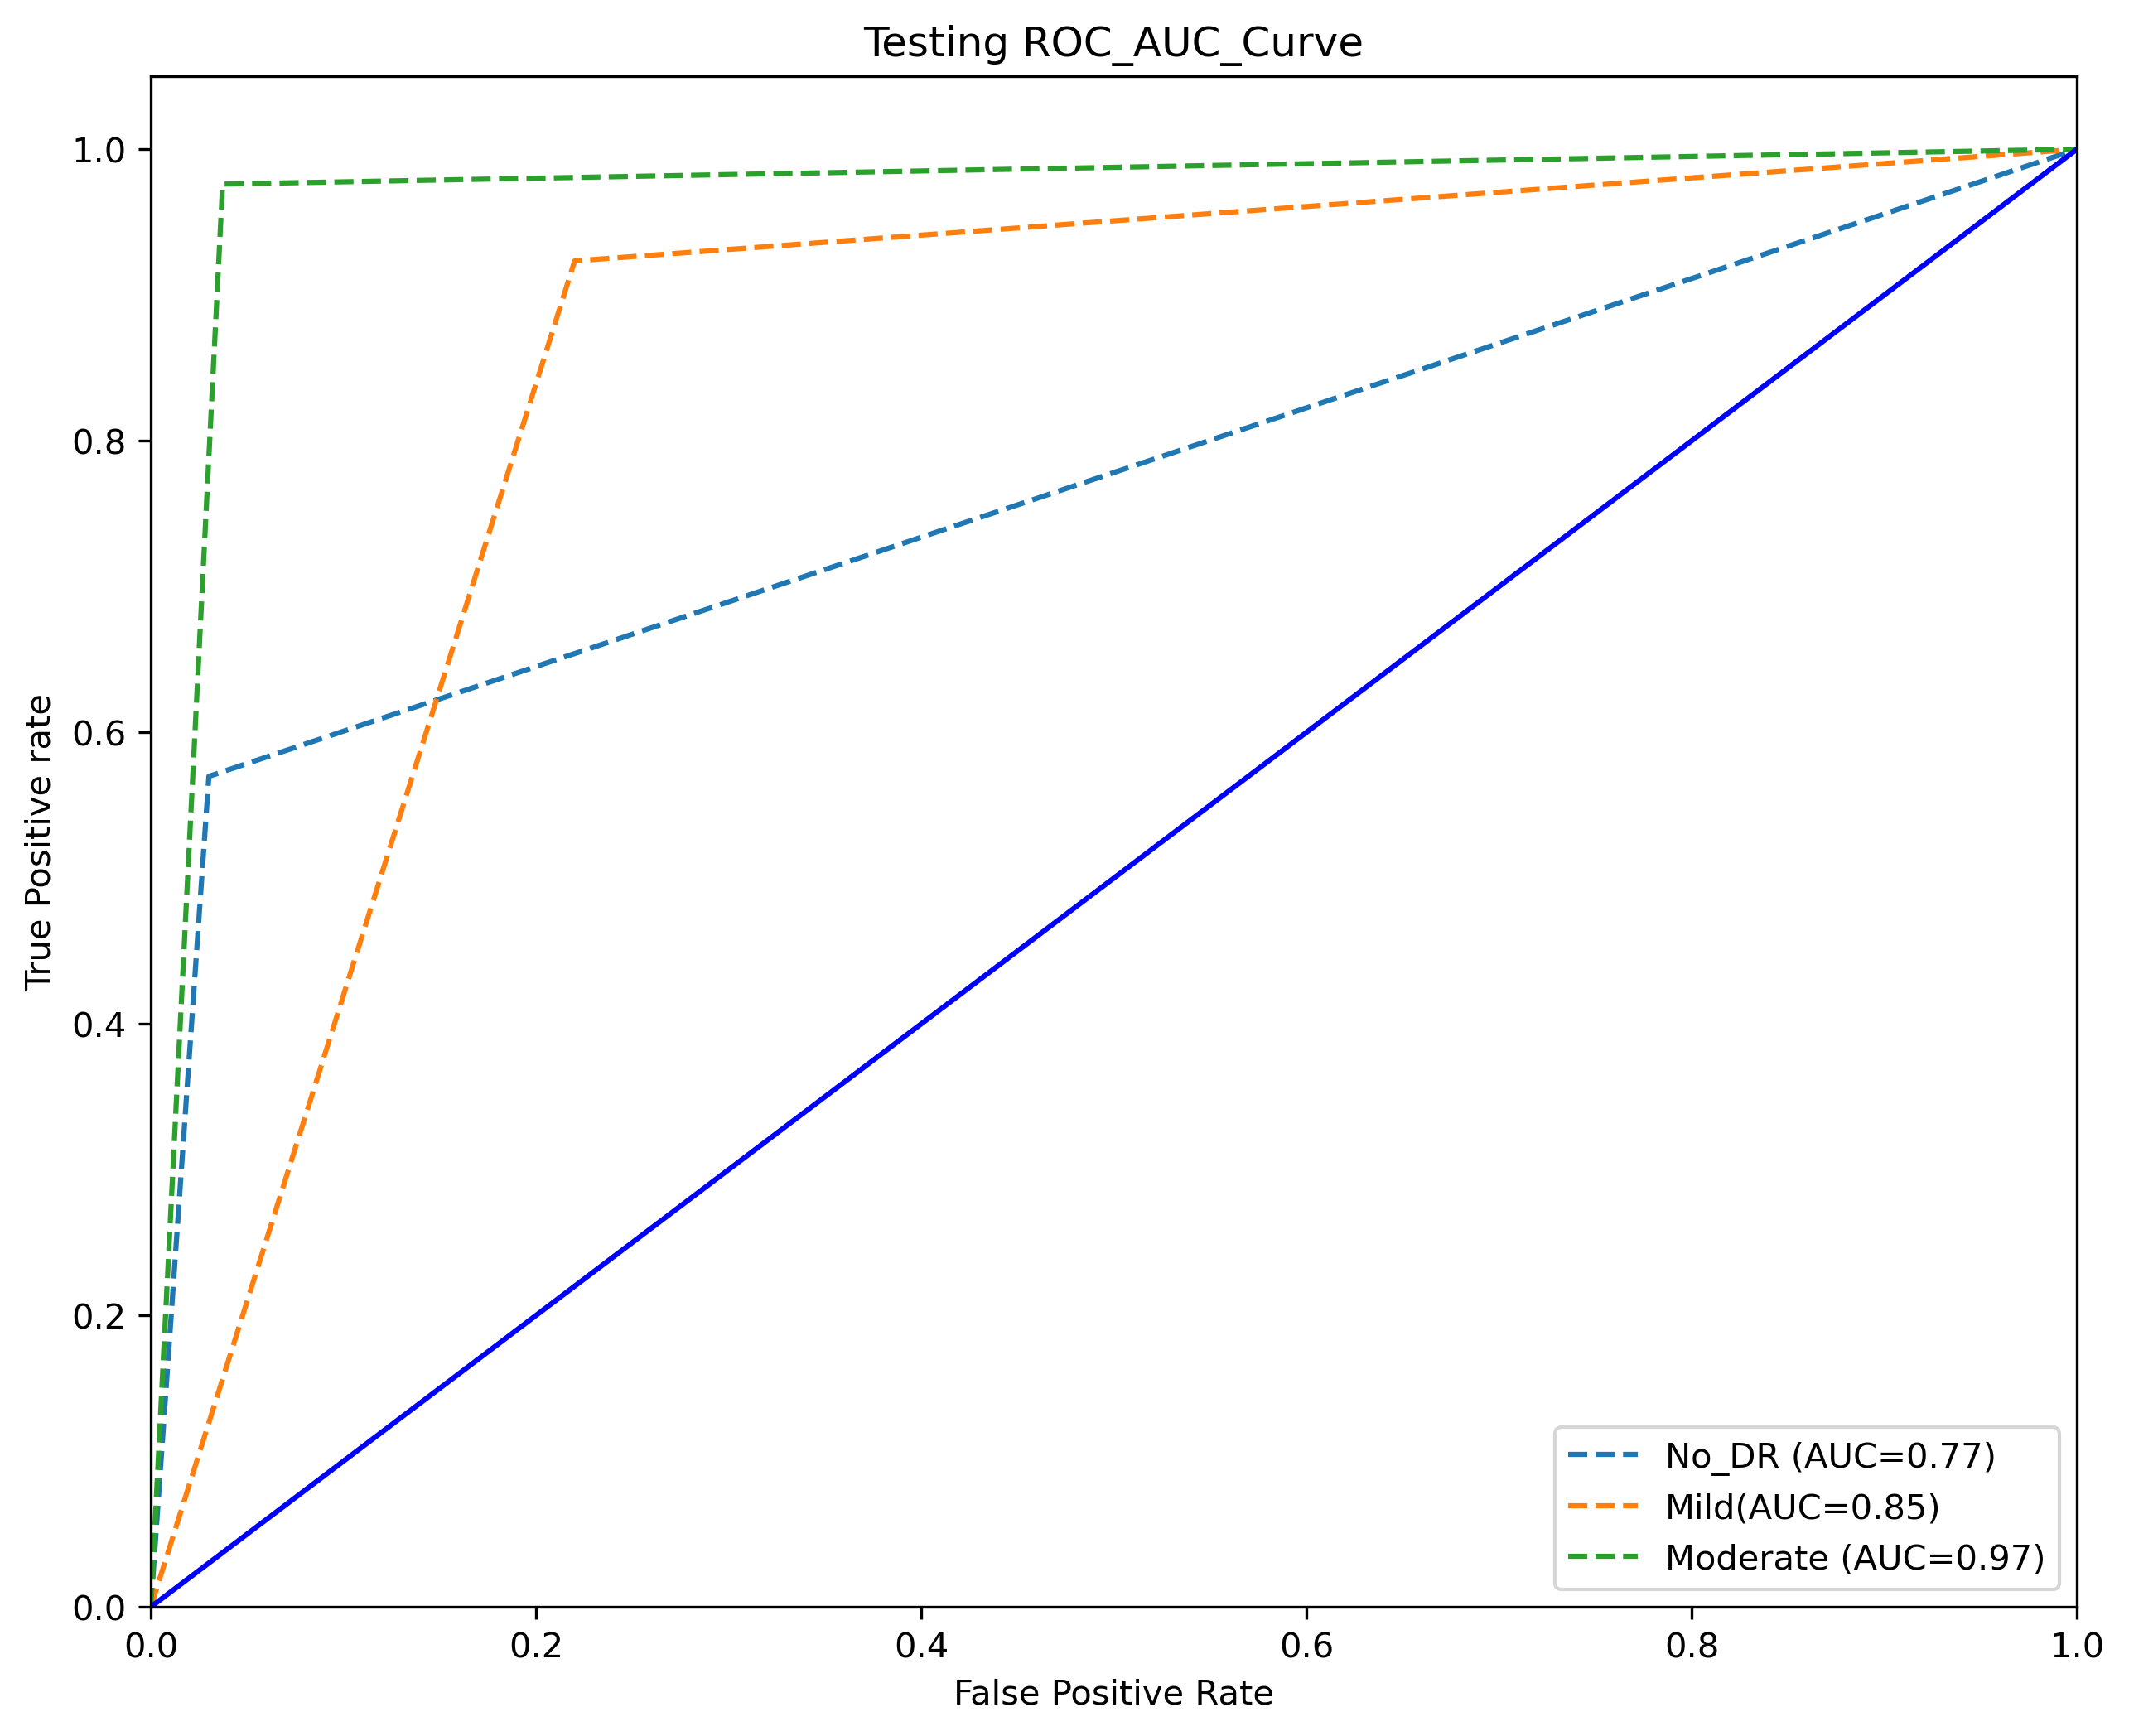

In [40]:
fpr = dict()
tpr = dict()
thresh =dict()
roc_auc = dict()

n_class = classes.shape[0]

fig=plt.figure(figsize=(10, 8), dpi=300)
for i in zip(range(n_class)):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(test_labels[:,i],pred_labels[:,i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    if classes[i]==0:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='No_DR (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==1:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Mild(AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==2:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Moderate (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==3:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Severe (AUC=%0.2f)'%(roc_auc[i]))
    if classes[i]==4:
        plt.plot(fpr[i], tpr[i], linestyle='--',label='Proliferate_DR (AUC=%0.2f)'%(roc_auc[i]))
plt.plot([0,1],[0,1],'b-')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Testing ROC_AUC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()
fig.savefig('myfig_EfficientNet_testing-79_5.png',dpi=300)# roc curve for classes